# Evolution of a Game

The game of baseball revolves around at bats, where the batter comes up to the plate to face off against a pitcher. Every at bat, a hitter can do a pleathora of things, many of which even a non-baseball fan is familar with. For example, there is the home run, where the ball goes over the outfield wall and a run scores. A strikeout, where 3 strikes have been thrown, causing an out, or its opposite: a walk, where 4 balls have been thrown, awarding the batter with a free base. There are many more: the single, double, triple, groundout, sac fly, etc.

Some have always been more common than others. It's no surprise that batters get out more than they hit home runs. However, over the lifetime of the game, the rate at which each happens evolves, reflecting changes in the game itself. Let's look a little deeper into these changes.

For this, I will use the Lahman Database, a large collection of baseball statistics going back to the 1800s. It can be found on Sean Lahman's website: https://www.seanlahman.com/baseball-archive/statistics/. For the sake of simplicity, I'll just be using the "Teams.csv" file, which contains the major statistics for each team and each season. The range of seasons, or years, will be 1920-2021, as 1920 was the first year which used the same type of physical baseball as the one used today.

Since the statistics are mostly just total counts, I do a small bit of math to turn them into the rate per 9 innings, which is the length of a baseball game. For example, 7.0 K/9 means there were an average of seven strikeouts per game.

I will use five common outcomes of an at bat: strikeout (K), walk (BB), single (1B), double (2B), and home run (HR). The change in these statistics can be seen in the following chart, made with the Altair code below.

In [48]:
import pandas as pd
import altair as alt

# Read
data = pd.read_csv('Teams.csv')

data['yearID'] = pd.to_datetime(data['yearID'], format='%Y')

# Filter out years before 1920, group by year, and remove non-numeric data
data = data[data['yearID'].dt.year >= 1920]
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
data = data.groupby(df['yearID'].dt.year)[numeric_cols].mean()

# Save
data.to_csv('Teams_A.csv')

In [56]:
# Read in the CSV file
data = pd.read_csv('Teams_A.csv')

# Renaming yearID to Year
data = data.rename(columns={'yearID': 'Year'})

# Calculate HR/9, K/9, BB/9, 1B/9, 2B/9
data['HR/9'] = 27 * data['HR'] / data['IPouts']
data['K/9'] = 27 * data['SO'] / data['IPouts']
data['BB/9'] = 27 * data['BB'] / data['IPouts']
data['1B'] = data['H'] - data['HR'] - data['3B'] - data['2B']
data['1B/9'] = 27 * data['1B'] / data['IPouts']
data['2B/9'] = 27 * data['2B'] / data['IPouts']

# Save
data.to_csv('Teams_B.csv', index=False)

# Chart
alt.Chart(data).transform_fold(
    ['HR/9', 'K/9', 'BB/9', "1B/9", "2B/9"]
).mark_line().encode(
    x=alt.X('Year:O', axis=alt.Axis(labelExpr='datum.value % 10 == 0 ? datum.value : ""')),
    y='value:Q',
    color='key:N'
).properties (
    title="At Bat Results Over Time",
    width=800,
    height=500
)

alt.Chart(...)

It's clear that some things have changed. Today, there are significantly fewer singles and significantly more strikeouts. It's not the easiest to see on this chart, but walks and doubles have remained mostly the same, with a few seemingly random spikes and dips along the way. The home runs have increased, though it too is a bit difficult to see.

I want to focus on two of these statistics: strikeouts and home runs. Instead of comparing all 5, let us instead look at just those two, and this time the chart will be adjusted to better view their changes. It is also made with Altair using the code below.

In [57]:
base = alt.Chart(data).encode(
    alt.X('Year:O', axis=alt.Axis(labelExpr='datum.value % 10 == 0 ? datum.value : ""'))
)

hr = base.mark_line(color='green').encode(
    alt.Y('HR/9', axis=alt.Axis(title='HR/9', titleColor='green'))
)

k = base.mark_line(stroke='red', interpolate='monotone').encode(
    alt.Y('K/9', axis=alt.Axis(title='K/9', titleColor='red'))
)

alt.layer(hr, k).resolve_scale(
    y = 'independent'
).properties(
    title="HR/9 and K/9 Over Time",
    width=800,
    height=500
)

alt.LayerChart(...)

This is much more revealing than the past chart. Strikouts and home runs have very clearly increased, both doubling or nearly tripling where they began at. More interesting than the growth is the similarity in the rate of growth. It seems as if they have been increasing by the same relative amount since 1920.

Why is this? A home run doesn't really have anything to do with a strikeout; it's not like a strikeout becomes a home run if you hit the ball just a little farther. In fact, they are polar opposites. Each represents the best outcome for one side of the ball. Every batter goes to the plate wanting to hit a home run, and every pitcher wants to strike the batter out. It is possible that everyone is just better at the game. After all, they've had 100 years to improve training regiments and workout plans. Is it possible for both sides to be better, though?

There are many ways to measure who is "better," none of them conclusive. This dataset has relatively rudimentary statistics, but we can work with what we're given. After every at bat, either the hitter's team or the pitcher's team has improved their chance of winning. Though it may be small, every at bat represents a potential "victory" for the hitter or the pitcher. Is there a way to tell who won? Somewhat. Every time he goes to the plate, a hitter can:

    1. Get a base hit
    2. Get walked
    3. Get out via a fielded ball
    4. Get out via a strikeout
    5. Other (get hit by the pitch, get ejected, catcher's interference)
    
As you may imagine, we will consider (1) and (2) to be a "win" for the hitter, and (3) and (4) to be a "win" for the pitcher. (5) is rare enough to ignore for this simple story.

Formally, I will use the following formula to determine the "hitter win percentage," or "HWin%":

* HWin% = (BB + H) / (AB + BB)

And similarly the "pitcher win percentage" or "PWin%":

* PWin% = (AB - H) / (AB + BB)

_Minor baseball statistic note: A walk (BB) does not count as a formal at bat (AB). Thus, I add the walks to the at bats to get the true number of at bats, or "plate appearances." Also, BWin% + PWin% is very, very close to 1 for each season (as expected)._
 
Now that we finally have our definition of a hitter and pitcher victory, let's observe how they have evolved over the years. This can be seen with a percent stacked area chart made in Charticulator.

In [60]:
# Read
data = pd.read_csv('Teams_B.csv')

# Add HW% and PW%
data["HW%"] = (data["BB"] + data["H"]) / (data["AB"] + data["BB"])
data["PW%"] = (data["AB"] - data["H"]) / (data["AB"] + data["BB"])

# For Charticulator ease
data = data.drop(columns=[col for col in data.columns if col not in ['Year', 'PW%', 'HW%']])

# Save
data.to_csv('Teams_C.csv', index=False)

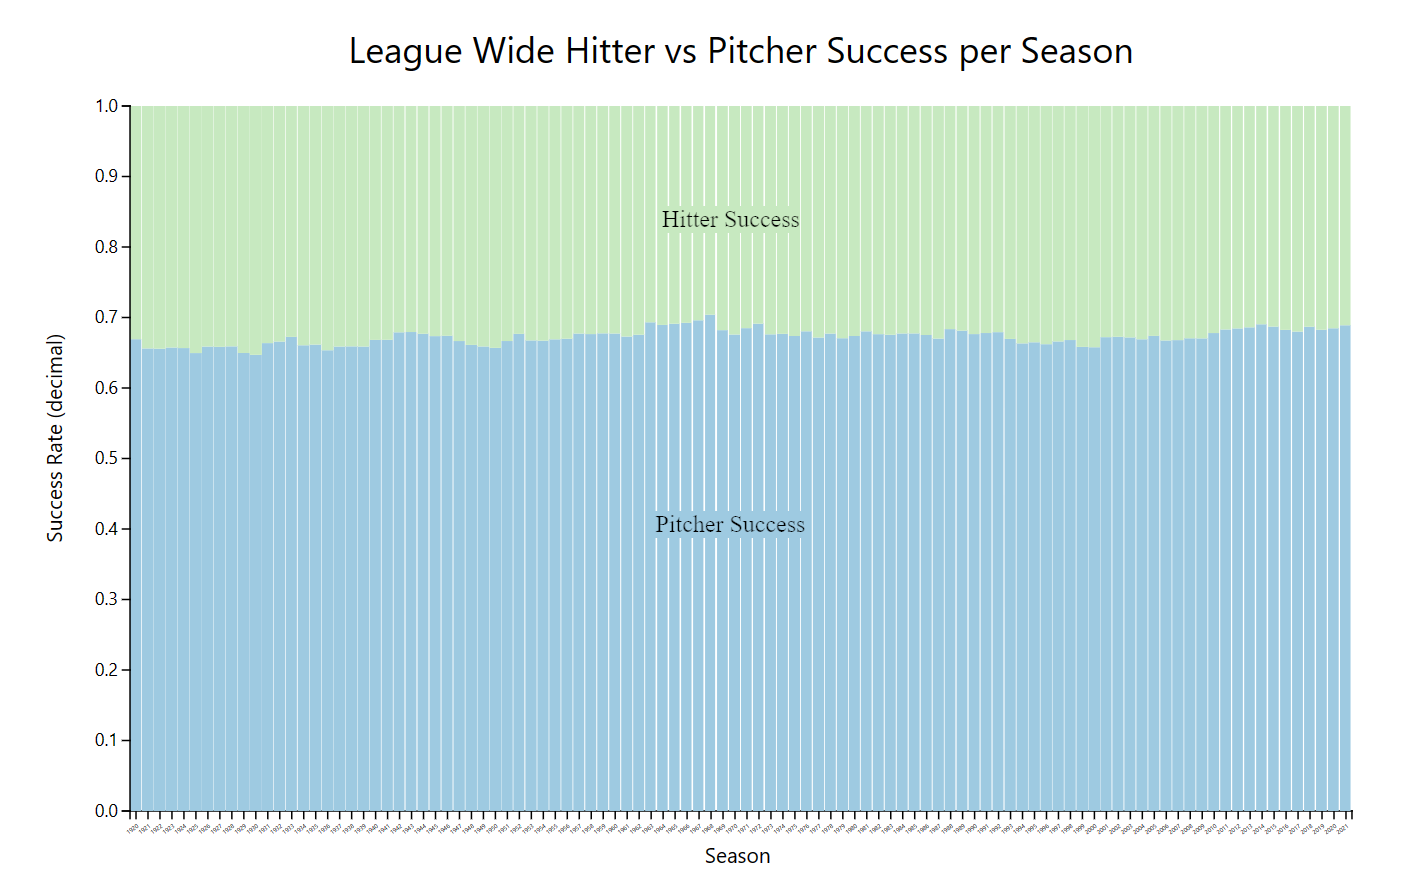

It looks as if the balance has remained in the pitcher's favor since 1920. There is a very slight trend of pitchers having more success, but not nearly enough to outright declare that either side has gotten observably better. Of course, players have gotten better. A player from 1920 likely wouldn't even make a Major League roster now. Luckily for the game though, both sides seem to have improved at a similar rate, enough to keep the game as competetive as it is today.

So why the huge uptick in strikouts and home runs? And why have they grown together? It is actually something that can't be measured with statistics, at least not the ones in the Lahman database. There has been an ever-present trend in the game to focus on the home run. It looks better in contract negotiations, it's more exciting to watch, and it has to be more satisfying for the hitter. However, hitting home runs isn't easy. If you go up to the plate trying to hit one, you are going to be swinging hard and wild, and that's a recipe for strikeouts. The harder you swing, the farther the ball goes, but you also have less control over the bat. That causes this relation between home runs and strikeouts. Its not unlike interceptions and touchdown for a quarterback. Their throws are more risky in hopes of a long ball, but that comes at the cost of being more open to getting picked.

It seems undeniable that players, and thus their teams, are adopting this mentality, perhaps at their manager's dismay. Is it really a valid strategy to swing for the fences? Let us finally look at how this ratio of striking out to hitting a home run (K/HR) plays into team success. Below is a chart that compares a team's strikeout per home run rate to their win percentage. The higher a point is, the more they struck out relative to how often they hit a home run. The closer a point is to the right, the more success they had that season, measured by their win percent. The larger a dot is, the more home runs that team hit, providing a higher sample size.

Made in D3. Below is an image of the chart. View the interactive version of the chart [here](https://comp790-infovis.github.io/module-two-data-three-ways-rceglie/chart3.html).

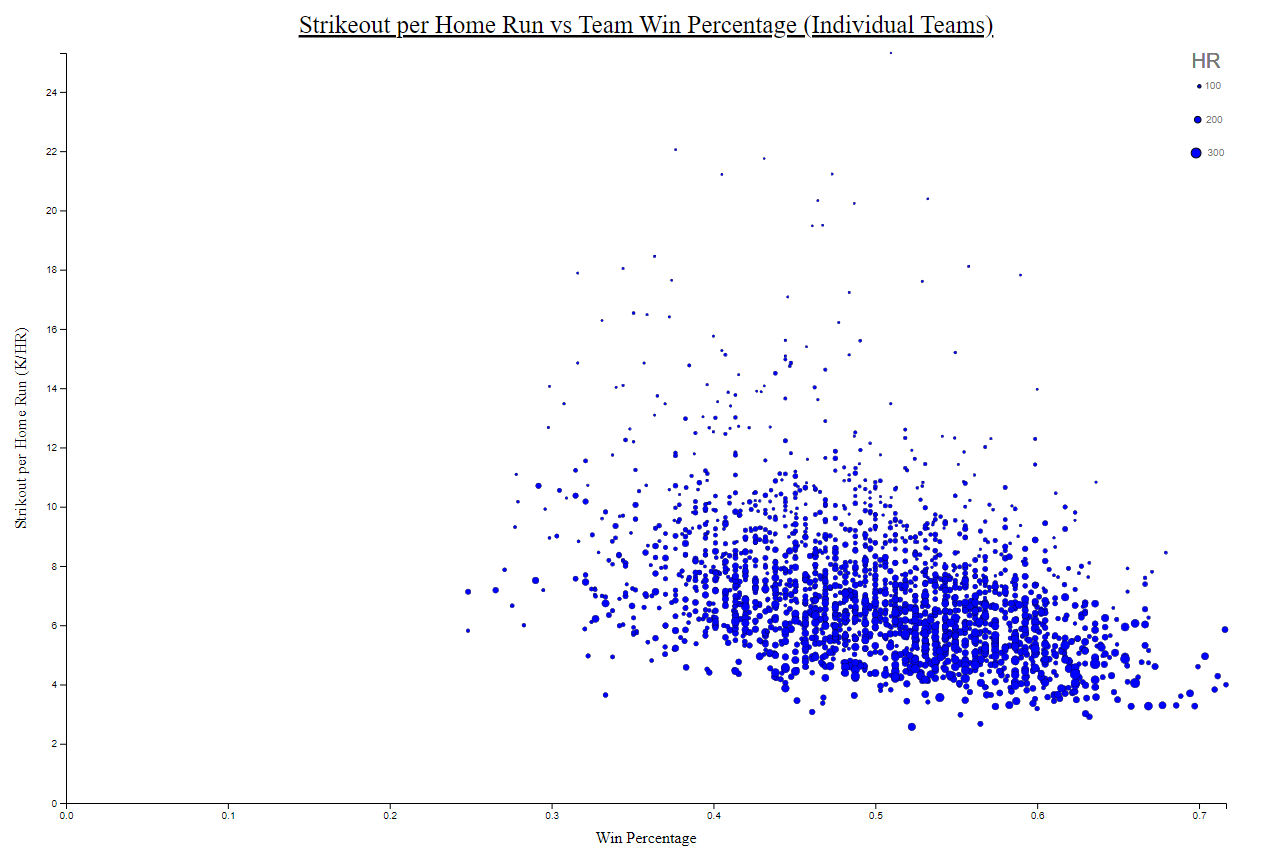

It's hard to draw a definite conclusion from this graph. There does appear to be a very general trend suggesting that a lower K/HR correlates with a higher win percentage. This makes sense, as strikeouts are detrimental to winning and home runs are beneficial. With the limited data supplied in the Lahman database, one could make the statement that a team should focus on lowering their K/HR rate. However, it would naive to immidiately attribute this relation to causation. It would take much more data, and statistics that have only been around for a few years, to make a more accurate conclusion.

Regardless, it is a fascinating relationship to analyze, and one that still remains a central talking point of the baseball statistics community today. Whether the community likes it or not, the sport has entered a new age, one revolving around terms like "exit velocity" and "spin rate," words that even the most tech-savvy managers in the 1900s never heard of. More than any other sport, baseball is one of data. Every pitch carries an incredible amount of information waiting to be uncovered by a curious eye.